In [49]:
import numpy as np
from typing import Any, Dict, List, Optional, Sequence, Tuple
from drn_interactions.transforms.spikes import SpikesHandler
from drn_interactions.io import load_derived_generic


class SpikeTrainLoader:
    def __init__(
        self,
        session_name: str,
        duration: float = 5.0,
        max_neurons: Optional[int] = None,
        block="pre"
    ):
        self.session_name = session_name
        self.duration = duration
        self.block=block
        neurons = load_derived_generic("neuron_types.csv").loc[lambda x: x["session_name"] == session_name]
        self.max_neurons =max_neurons
        self.neurons = neurons
    
    def get_trians_by_type(self, t_start) -> Dict[str, List[np.ndarray]]:
        types = self.neurons.neuron_type.unique()
        trains = {}
        for neuron_type in types:
            neurons = self.neurons.loc[lambda x: x["neuron_type"] == neuron_type]["neuron_id"].values
            trains[neuron_type] = self.get_trains(t_start, ids=neurons)
        return trains

    def get_trains(
        self, t_start, ids: Optional[Sequence] = None
    ) -> List[np.ndarray]:
        if ids is None:
            ids = self.neurons["neuron_id"].values
        
        sh = SpikesHandler(
            bin_width=1, session_names=[self.session_name], t_start=t_start, t_stop=t_start + self.duration, block=self.block
        )
        df_spikes = sh.spikes.loc[lambda x: x["neuron_id"].isin(ids)]
        trains = [
            dfg["spiketimes"].values for _, dfg in df_spikes.groupby("neuron_id")
        ]
        trains = trains[:self.max_neurons]
        return trains


import matplotlib.pyplot as plt


def make_grid(
    trains: Dict[Any, str], fig: Optional[plt.Figure] = None, gridspec_kw: Optional[Dict] = None, type_order=None,
):
    fig = fig or plt.figure()
    neuron_types = type_order or list(trains.keys())
    n_rows = len(neuron_types)
    n_cols = 1
    height_ratios = np.array([len(trains[neuron_type]) for neuron_type in neuron_types])
    height_ratios = height_ratios / height_ratios.sum()
    gridspec_kw = gridspec_kw or {}
    gridspec_kw["height_ratios"] = height_ratios
    axes = fig.subplots(n_rows, n_cols, gridspec_kw=gridspec_kw)
    return axes


def plot_raster(trains: List[np.ndarray], ax=None, **eventplot_kwargs):
    ax = ax or plt.subplots()[1]
    ax.eventplot(
        trains,
        **eventplot_kwargs,
    )
    ax.axis("off")
    return ax


def plot_raster_grouped(
    trains: Dict[str, List[np.ndarray]],
    fig=None,
    eventplot_kwargs: Optional[Dict] = None,
    gridspec_kw: Optional[Dict] = None,
    type_order: Optional[List[str]] = None,
):
    eventplot_kwargs = eventplot_kwargs or {}
    gridspec_kw = gridspec_kw or {}
    
    fig = fig or plt.figure()
    neuron_types = type_order or list(trains.keys())
    axes = make_grid(
        trains,
        fig=fig,
        gridspec_kw=gridspec_kw,
        type_order=neuron_types
    )
    
    for ax, neuron_type in zip(axes, neuron_types):
        train_list = trains[neuron_type]
        plot_raster(train_list, ax=ax, **eventplot_kwargs)
    return fig, axes

def plot_raster_grouped_time(
    trains: List[Dict[str, List[np.ndarray]]],
    fig: plt.Figure =None,
    eventplot_kwargs: Optional[Dict] = None,
    gridspec_kw: Optional[Dict] = None,
    type_order: Optional[List[str]] = None,

):
    fig = fig or plt.figure()

    num_timepoints = len(trains)
    sub_figs = fig.subfigures(1, num_timepoints)

    for sub_fig, train in zip(sub_figs, trains):
        plot_raster_grouped(
            train,
            fig=sub_fig,
            eventplot_kwargs=eventplot_kwargs,
            gridspec_kw=gridspec_kw,
            type_order=type_order,
        )
    return fig

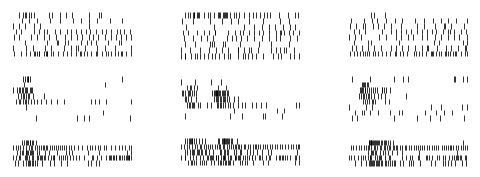

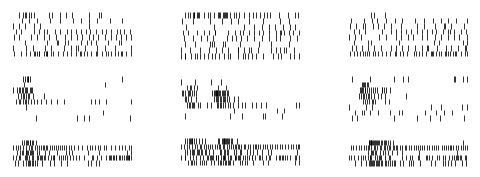

In [77]:
session_name = "acute_15"

loader = SpikeTrainLoader(session_name, duration=5.0, max_neurons=8)

trains_second = loader.get_trians_by_type(t_start=300)
trains_third = loader.get_trians_by_type(t_start=600)
trains_fourth = loader.get_trians_by_type(t_start=1000)

f = plt.figure(figsize=(7, 3))
plot_raster_grouped_time(
    fig=f,
    trains=[trains_second, trains_third, trains_fourth],
    type_order=["SR", "SIR", "FF"],
    eventplot_kwargs={"color": "k", "linewidths": 0.8},
)

